### Data as phrases. Augmentation after validation. Attach user id after 1st RNN

In [1]:
# -*- coding: utf-8 -*-
import os
import sys
import csv
import time
import json
import datetime
import pickle as pkl
import tensorflow as tf
import collections
from collections import Counter
import data_helper_HRE
#import data_helper
#from rnn_classifier import rnn_clf
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
tf.__version__

/home/anastasia/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.7.0'

In [2]:
# Parameters
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
FLAGS = AttrDict()

In [8]:
# Model parameters
FLAGS['clf'] =  'gru' # Type of classifiers
# Data parameters
FLAGS['data_file'] = 'data/ev_thread_HRE.csv'
FLAGS['emb_file'] = "./glove.6B/glove.6B.100d.txt"


FLAGS['test_size'] =  0.1 # 'Cross validation test size'

# Model hyperparameters

FLAGS['hidden_size1'] =  100 #'Number of hidden units in the GRU cell
FLAGS['hidden_size2'] =  100 
FLAGS['embedding_size'] = 100
FLAGS['num_layers1'] =  1
FLAGS['num_layers2'] =  1 
FLAGS['keep_prob'] =  1 
FLAGS['learning_rate'] =  3e-4 # 'Learning rate' 
FLAGS['l2_reg_lambda'] =  0 # 'L2 regularization lambda'

# Training parameters
FLAGS['batch_size'] = 100 # 'Batch size'
FLAGS['num_epochs'] = 40 # 'Number of epochs'
FLAGS['evaluate_every_steps'] = 10 # 'Evaluate the model on validation set after this many steps'
FLAGS['random_state'] = 7

In [9]:
# Load data and transform to embeddings
data_is_loaded = True

if data_is_loaded == False:
    data = pd.read_json("./data/dataset.json", lines=True)
    data_cleaned = data_helper_HRE.clean_data(data, 2, 200) #saves changed data to ev_thread_HRE.csv
    ids, users, data, labels, lengths_th, lengths_utt, vocab_embs = data_helper_HRE.data_to_emb(data_file_path=FLAGS.data_file,
                                                               emb_file_path=FLAGS.emb_file)
    np.savez("data/data_to_train_HRE.npz", ids=ids, users=users, data=data, labels=labels, lengths_th=lengths_th, lengths_utt=lengths_utt, vocab_embs=vocab_embs)
else:
    data_dict = np.load("data/data_to_train_HRE.npz")
    ids = data_dict['ids']
    users = data_dict['users']
    data = data_dict['data']
    labels = data_dict['labels']
    lengths_th = data_dict['lengths_th']
    lengths_utt = data_dict['lengths_utt']
    vocab_embs = data_dict['vocab_embs']
FLAGS.vocab_size = vocab_embs.shape[1]

In [10]:
class rnn_clf(object):
    """"
    Hierarchical RNN classifier with GRU cell
    """
    def __init__(self, config):
        #self.num_classes = config.num_classes
        self.vocab_size = config.vocab_size
        self.hidden_size1 = config.hidden_size1
        self.hidden_size2 = config.hidden_size2
        self.embedding_size = config.embedding_size
        self.num_layers1 = config.num_layers1
        self.num_layers2 = config.num_layers2
        self.l2_reg_lambda = config.l2_reg_lambda

        # Placeholders
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[])
        self.input_x = tf.placeholder(dtype=tf.int32, shape=[None, None, None])
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None])
        self.keep_prob = tf.placeholder(dtype=tf.float32, shape=[])
        self.lengths_th = tf.placeholder(dtype=tf.int32, shape=[None])
        self.lengths_utt = tf.placeholder(dtype=tf.int32, shape=[None, None])
        self.users = tf.placeholder(dtype=tf.float32, shape=[None, None, 2])


        # L2 loss
        self.l2_loss = tf.constant(0.0)
        
       
        
        # Word embedding
        self.embedding = tf.placeholder(shape=[self.vocab_size, self.embedding_size], dtype=tf.float32)

        # Input dropout
        #self.inputs = tf.nn.dropout(inputs, keep_prob=self.keep_prob)
        max_utt_number = tf.shape(self.input_x)[1]
       # inputs2 = tf.zeros([self.batch_size, max_utt_number, self.hidden_size1], dtype=tf.float32)
       
        if config.clf == 'gru':
            inputs2 = tf.TensorArray(dtype=tf.float32, size=self.batch_size, element_shape=[None, None])
            def body(th_idx, inputs2):
                th_length = self.lengths_th[th_idx]
                th = self.input_x[th_idx]
                th = th[:th_length]
                seq_length = self.lengths_utt[th_idx, :th_length]
                inputs1 = tf.nn.embedding_lookup(self.embedding, th)
                
                _, final_state1 = self.normal_gru(variable_scope="GRU1", hidden_size=self.hidden_size1,
                                               num_layers=self.num_layers1, batch_size=th_length, inputs=inputs1, sequence_length=seq_length )
                
                zeros = tf.zeros([max_utt_number - th_length, self.hidden_size1], dtype=tf.float32)
                final_state1_with_zeros = tf.concat([final_state1, zeros], axis=0)
            
                inputs2 = inputs2.write(th_idx, final_state1_with_zeros)
                return th_idx + 1, inputs2
            def condition(th_idx, _):
                return th_idx < self.batch_size
            init_state = (0, inputs2)
            
            _, inputs2_final = tf.while_loop(condition, body, init_state)
            # get the final result
            inputs2_final_result = inputs2_final.stack()
            inputs2_final_result = tf.concat([inputs2_final_result, self.users], axis=2)
         
            

                
        _, self.final_state2 = self.normal_gru(variable_scope="GRU2", hidden_size=self.hidden_size2,
                                               num_layers=self.num_layers2, batch_size=self.batch_size,
                                               inputs=inputs2_final_result, sequence_length=self.lengths_th)

        # Softmax output layer
        with tf.name_scope('softmax'):
            # softmax_w = tf.get_variable('softmax_w', shape=[self.hidden_size, self.num_classes], dtype=tf.float32)
            if config.clf == 'gru':
                output_w = tf.get_variable('output_w', shape=[self.hidden_size2, 1], dtype=tf.float32)
            
            output_b = tf.get_variable('ouput_b', shape=[1], dtype=tf.float32)

            # L2 regularization for output layer
            self.l2_loss += tf.nn.l2_loss(output_w)
            self.l2_loss += tf.nn.l2_loss(output_b)

            if config.clf == 'gru':
                self.output = tf.matmul(self.final_state2, output_w) + output_b

       
            self.predictions = tf.reshape(self.output, [-1])

        # Loss
        with tf.name_scope('loss'):
            tvars = tf.trainable_variables()

            # L2 regularization for LSTM weights
            for tv in tvars:
                if 'kernel' in tv.name:
                    self.l2_loss += tf.nn.l2_loss(tv)

            losses = tf.losses.mean_squared_error(labels=self.input_y, predictions=self.predictions)
            self.cost = tf.reduce_mean(losses) + self.l2_reg_lambda * self.l2_loss

        # Accuracy
        with tf.name_scope('accuracy'):
            correct_predictions = tf.equal(tf.round(self.predictions), tf.round(self.input_y))
            self.correct_num = tf.reduce_sum(tf.cast(correct_predictions, tf.float32))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
            #self.accuracy = tf.contrib.metrics.streaming_accuracy(tf.to_float(self.predictions), tf.to_float(self.input_y))
        with tf.name_scope('pearson'):
            #self.pearson = tf.contrib.metrics.streaming_pearson_correlation(tf.to_float(self.predictions), tf.to_float(self.input_y))
            self.pearson, self.cov, self.var_y_pred, self.var_y_true = self.pearson_f()
            
    def pearson_f(self):
        y_pred = tf.to_float(self.predictions)
        y_true = tf.to_float(self.input_y)
        mean_y_pred, var_y_pred = tf.nn.moments(y_pred, axes=0)
        mean_y_true, var_y_true = tf.nn.moments(y_true, axes=0)
        cov = tf.nn.moments(tf.multiply(y_pred, y_true), axes = 0)[0] - mean_y_pred * mean_y_true
        var_mult = tf.multiply(var_y_pred, var_y_true)
        pearson_corr = tf.divide(cov, tf.sqrt(var_mult))
        return pearson_corr, cov, var_y_pred, var_y_true
        
    def normal_lstm(self):
        # LSTM Cell

        cell = tf.contrib.rnn.LSTMCell(self.hidden_size1,
                                       forget_bias=1.0,
                                       state_is_tuple=True,
                                       reuse=tf.get_variable_scope().reuse)
        # Add dropout to cell output
        #cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob)
        # Stacked LSTMs
        cell = tf.contrib.rnn.MultiRNNCell([cell] * self.num_layers, state_is_tuple=True)

        self._initial_state = cell.zero_state(self.batch_size, dtype=tf.float32)

        # Dynamic LSTM
        with tf.variable_scope(''):
            outputs, state = tf.nn.dynamic_rnn(cell,
                                               inputs=self.inputs,
                                               initial_state=self._initial_state,
                                               sequence_length=self.sequence_length)

        final_state = state
        return final_state
        
    def normal_gru(self, variable_scope, hidden_size, num_layers, batch_size, inputs, sequence_length):
        # GRU Cell

        cell = tf.contrib.rnn.GRUCell(hidden_size,
                                       reuse=tf.get_variable_scope().reuse)
        # Add dropout to cell output
        #cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob)
        # Stacked LSTMs
        cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)

        self._initial_state = cell.zero_state(batch_size, dtype=tf.float32)

        # Dynamic LSTM
        with tf.variable_scope(variable_scope):
            outputs, state = tf.nn.dynamic_rnn(cell,
                                               inputs=inputs,
                                               initial_state=self._initial_state,
                                               sequence_length=sequence_length)

        final_state = state[num_layers - 1]

        return outputs, final_state
    def bi_gru(self, variable_scope, hidden_size, num_layers, batch_size, inputs, sequence_length):
        cell_fw = tf.contrib.rnn.GRUCell(hidden_size,
                                       reuse=tf.get_variable_scope().reuse)

        cell_bw = tf.contrib.rnn.GRUCell(hidden_size,
                                       reuse=tf.get_variable_scope().reuse)


        # Add dropout to cell output
        #cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, output_keep_prob=self.keep_prob)
        #cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, output_keep_prob=self.keep_prob)

        # Stacked LSTMs
        cell_fw = tf.contrib.rnn.MultiRNNCell([cell_fw] * num_layers, state_is_tuple=True)
        cell_bw = tf.contrib.rnn.MultiRNNCell([cell_bw] * num_layers, state_is_tuple=True)

        self._initial_state_fw = cell_fw.zero_state(batch_size, dtype=tf.float32)
        self._initial_state_bw = cell_bw.zero_state(batch_size, dtype=tf.float32)

        # Dynamic Bi-LSTM
        with tf.variable_scope(variable_scope):
            _, state = tf.nn.bidirectional_dynamic_rnn(cell_fw,
                                                       cell_bw,
                                                       inputs=inputs,
                                                       initial_state_fw=self._initial_state_fw,
                                                       initial_state_bw=self._initial_state_bw,
                                                       sequence_length=sequence_length)

        state_fw = state[0]
        state_bw = state[1]
        output = tf.concat([state_fw[num_layers - 1], state_bw[num_layers - 1]], 1)

        return output
   

In [11]:
# Train
# Prints minimal validation loss, max pearson, max spearman
def train(FLAGS=FLAGS):
    #split dataset
    users_train, users_valid, x_train, x_valid, y_train, y_valid, train_lengths_th, valid_lengths_th, train_lengths_utt, valid_lengths_utt = data_helper_HRE.my_train_test_split(ids, users, data,
                                                                                    labels,
                                                                                    lengths_th, lengths_utt,
                                                                                    test_size=FLAGS.test_size,
                                                                                    random_state=FLAGS.random_state)
    #batch iterator
    train_data = data_helper_HRE.batch_iter(users_train,  x_train, y_train, train_lengths_th, train_lengths_utt, FLAGS.batch_size, FLAGS.num_epochs)
    train_costs = []
    valid_costs = []
    train_pearson = []
    valid_pearson = []
    valid_spearman = []

    with tf.Graph().as_default():
        with tf.Session() as sess:
            if FLAGS.clf == 'gru':
                classifier = rnn_clf(FLAGS)
            #print(tf.trainable_variables())

            # Train procedure
            global_step = tf.Variable(0, name='global_step', trainable=False)
            optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
            grads_and_vars = optimizer.compute_gradients(classifier.cost)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)



            sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))


            def run_step(input_data, is_training=True, print_predictions=False):
                """Run one step of the training process."""
                users, input_x, input_y, lengths_th, lengths_utt = input_data
                fetches = {'step': global_step,
                           'cost': classifier.cost,
                           'accuracy': classifier.accuracy, 
                           'pearson': classifier.pearson,
                           'cov': classifier.cov,
                           'var_y_true': classifier.var_y_true,
                           'var_y_pred': classifier.var_y_pred}
                feed_dict = {classifier.input_x: input_x,
                             classifier.input_y: input_y,
                             classifier.users: users}

                fetches['predictions'] = classifier.predictions


                fetches['final_state'] = classifier.final_state2
                feed_dict[classifier.batch_size] = len(input_x)
                feed_dict[classifier.lengths_th] = lengths_th
                feed_dict[classifier.lengths_utt] = lengths_utt

                if is_training:
                    fetches['train_op'] = train_op
                    #fetches['summaries'] = train_summary_op
                    feed_dict[classifier.keep_prob] = FLAGS.keep_prob

                else:
                    #fetches['summaries'] = valid_summary_op
                    feed_dict[classifier.keep_prob] = 1.0
                feed_dict[classifier.embedding] = np.transpose(vocab_embs)

                vars = sess.run(fetches, feed_dict)
                step = vars['step']
                cost = vars['cost']
                accuracy = vars['accuracy']
                pearson = vars['pearson']
                predictions = vars['predictions']

                # Write summaries to file
                if is_training:
                    pass
                    #train_summary_writer.add_summary(summaries, step)
                else:
                    #valid_summary_writer.add_summary(summaries, step)

                    time_str = datetime.datetime.now().isoformat()
                    #print("{}: step: {}, loss: {:g}, accuracy: {:g}, pearson: {:g}".format(time_str, step, cost, accuracy, pearson))
                    #print("Cost:", cost)
                   
                if print_predictions:
                    #print('Predictions:')
                    #print(predictions)
                    #print('Labels:')
                    #print(input_y)
                    pass
                return cost, predictions


            print('Start training ...')
           
            tqdm_length = FLAGS.num_epochs * (len(x_train) // FLAGS.batch_size)
            for train_input in tqdm_notebook(train_data, total=tqdm_length):
                cost, predictions = run_step(train_input, is_training=True)
                current_step = tf.train.global_step(sess, global_step)

                if current_step % FLAGS.evaluate_every_steps == 0:
                    #print('\nTraining')
                    cost, predictions = run_step(train_input, is_training=False)
                    _, _, y_batch, _ , _= train_input
                    train_costs.append(cost)

                    train_pearson.append(pearsonr(predictions, y_batch.astype(np.float))[0])
                    #print('\nValidation')
                    cost, predictions = run_step((users_valid, x_valid, y_valid, valid_lengths_th, valid_lengths_utt), is_training=False)
                    valid_costs.append(cost)
                    y_valid = y_valid.astype(np.float)
                    valid_pearson.append(pearsonr(predictions, y_valid)[0])
                    valid_spearman.append(spearmanr(predictions, y_valid)[0])

                    #print('')


            run_step((users_valid, x_valid, y_valid, valid_lengths_th, valid_lengths_utt), is_training=False, print_predictions=True)
    
    print("Min loss = ", min(valid_costs))
    print("Max pearson = ", max(valid_pearson))
    print("Max spearman = ", max(valid_spearman))
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.plot(train_costs, label='train_costs', alpha=0.5, lw=3)
    plt.plot(valid_costs, label='valid_costs', alpha=0.5, lw=3)

    plt.title("Loss history")
    plt.legend()
    
  
    
    plt.subplot(212)
    plt.plot(train_pearson, label='train_pearson', alpha=0.5, lw=3)
    plt.plot(valid_pearson, label='valid_pearson', alpha=0.5, lw=3)

    plt.title("Pearson history")
    plt.legend()
    plt.show()
    
    return None

Start training ...


HBox(children=(IntProgress(value=0, max=280), HTML(value='')))


Min loss =  1.8753539
Max pearson =  0.3398126177318646
Max spearman =  0.3739713376502977


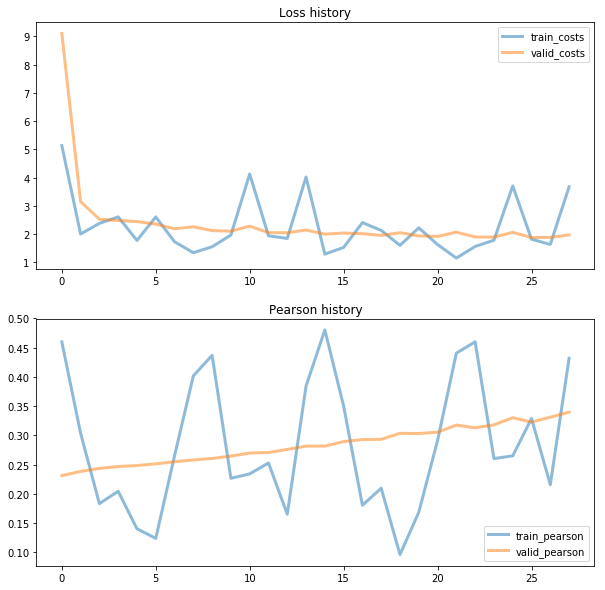

In [12]:
FLAGS['random_state'] = 5
train()